# Assignment 02 - Simple Clustering using Apache Spark
## 1. Preparation
### 1.1 Requirements

1. Operating System : Linux Mint 18.3 Sylvia
2. Apache Spark 2.4.0 Binary (https://spark.apache.org/downloads.html)
3. PySpark 2.4.0 (Apache Spark Python API)
4. Findspark 1.3.0 (Python's library)
5. Jupyter Notebook (https://jupyter.org/install)
6. matplotlib-3.0.3
7. bokeh-1.0.4
8. pixiedust-1.1.15
9. pandas-0.24.2

### 1.2 Installation
For Debian/Ubuntu-based Linux:
```bash
pip3 install matplotlib
pip3 install bokeh
pip3 install pixiedust
pip3 install pandas
```

### 1.3 Description of Dataset
* Dataset's name : [UK Road Safety : Traffic Accidents and Vehicles](https://www.kaggle.com/tsiaras/uk-road-safety-accidents-and-vehicles)
* Description : Detailed dataset of road accidents and involved vehicles in the UK (2005-2017). Each line represents a single traffic accident (identified by the Accident_Index column) and its various properties.
* There are two kinds of data sources in this dataset :

<table>
    <thead>
        <tr>
            <th>Data Sources</th>
            <th>Number of Rows</th>
            <th>Number of Columns</th>
            <th>Size</th>
            <th>File Format</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>Accident_Information.csv</td>
            <td>2047256</td>
            <td>34</td>
            <td>705,5 MB</td>
            <td rowspan=3>CSV</td>
        </tr>
        <tr>
            <td>Vehicle_Information.csv</td>
            <td>2177205</td>
            <td>24</td>
            <td>644,4 MB</td>
        </tr>
        <tr>
            <td colspan=3>Total</td>
            <td>1,3 GB</td>
        </tr>
    </tbody>
</table>
    
## 2. Spark Initialization

In [1]:
# Import findspark to make pyspark importable as a regular library
import findspark
findspark.init('/home/mocatfrio/spark') 

# /home/mocatfrio/spark has symbolic link to /bin/spark-2.4.0-bin-hadoop2.7

In [2]:
# Import required python library
from pyspark.sql import SparkSession

# Create Spark Session
spark = SparkSession \
    .builder \
    .appName("Simple Clustering") \
    .getOrCreate()

In [3]:
# Print spark object ID
print(spark)

## 3. Load Dataset

In [4]:
# Load the dataset
df = spark.read.load("/home/mocatfrio/Documents/projects/big-data/datasets/Accident_Information.csv", \
                     format="csv", sep=",", inferSchema="true", header="true")

In [5]:
# Print top 20 rows data
df.show()

+--------------+--------------+---------------+--------------+---------------+-----------------+-------------------+-------------------+-----------+-------------------------------------------+--------------------+--------------------+---------+--------------------+--------------------------+-------------------------+---------------------+----------------------+---------+-------------------------+--------------------+------------------+---------------------------------+---------------------------------------+-------------------+-----------------------+------------------+--------------------------+-----------+-----+-------------------+--------------------+----+----------+
|Accident_Index|1st_Road_Class|1st_Road_Number|2nd_Road_Class|2nd_Road_Number|Accident_Severity|Carriageway_Hazards|               Date|Day_of_Week|Did_Police_Officer_Attend_Scene_of_Accident|    Junction_Control|     Junction_Detail| Latitude|    Light_Conditions|Local_Authority_(District)|Local_Authority_(Highway)|Loc

In [6]:
# Count data rows
df.count()

2047256

In [7]:
# inferSchema is used to inference the actual datatype of columns, especially for dates and timestamp
df.printSchema()

root
 |-- Accident_Index: string (nullable = true)
 |-- 1st_Road_Class: string (nullable = true)
 |-- 1st_Road_Number: string (nullable = true)
 |-- 2nd_Road_Class: string (nullable = true)
 |-- 2nd_Road_Number: string (nullable = true)
 |-- Accident_Severity: string (nullable = true)
 |-- Carriageway_Hazards: string (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Day_of_Week: string (nullable = true)
 |-- Did_Police_Officer_Attend_Scene_of_Accident: string (nullable = true)
 |-- Junction_Control: string (nullable = true)
 |-- Junction_Detail: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Light_Conditions: string (nullable = true)
 |-- Local_Authority_(District): string (nullable = true)
 |-- Local_Authority_(Highway): string (nullable = true)
 |-- Location_Easting_OSGR: string (nullable = true)
 |-- Location_Northing_OSGR: string (nullable = true)
 |-- Longitude: string (nullable = true)
 |-- LSOA_of_Accident_Location: string (nullable = true)
 |-

## 4. Simple Clustering
We want to cluster some areas or points of frequent accidents in the UK (2015-2017) according to its latitude and longitude point. 

Following are the steps:

### 4.1 Preprocess Data

In [8]:
# Import col
from pyspark.sql.functions import col

In [9]:
# Convert the type of Latitude and Longitude values into float and remove null values
df_preprocessed = (df
       .withColumn("Latitude", col("Latitude").cast("float"))
       .withColumn("Longitude", col("Longitude").cast("float"))
       .dropna()
       )

In [10]:
df_preprocessed.printSchema()

root
 |-- Accident_Index: string (nullable = true)
 |-- 1st_Road_Class: string (nullable = true)
 |-- 1st_Road_Number: string (nullable = true)
 |-- 2nd_Road_Class: string (nullable = true)
 |-- 2nd_Road_Number: string (nullable = true)
 |-- Accident_Severity: string (nullable = true)
 |-- Carriageway_Hazards: string (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Day_of_Week: string (nullable = true)
 |-- Did_Police_Officer_Attend_Scene_of_Accident: string (nullable = true)
 |-- Junction_Control: string (nullable = true)
 |-- Junction_Detail: string (nullable = true)
 |-- Latitude: float (nullable = true)
 |-- Light_Conditions: string (nullable = true)
 |-- Local_Authority_(District): string (nullable = true)
 |-- Local_Authority_(Highway): string (nullable = true)
 |-- Location_Easting_OSGR: string (nullable = true)
 |-- Location_Northing_OSGR: string (nullable = true)
 |-- Longitude: float (nullable = true)
 |-- LSOA_of_Accident_Location: string (nullable = true)
 |-- 

In [11]:
df_preprocessed.count()

1902247

In [12]:
# Register the dataframe as a SQL temporary view
df_preprocessed.createOrReplaceTempView("traffic_accidents")

### 4.2 Retrieve Data

In [13]:
# Retrieve the data needed:
# - Latitude
# - Longitude
# - Value (In this case is Number of Casualties)

data = spark.sql("SELECT `Latitude` as lat, `Longitude` as lon, `Accident_Severity`, `Number_of_Casualties`\
                  FROM traffic_accidents")

In [14]:
data.show()

+---------+---------+-----------------+--------------------+
|      lat|      lon|Accident_Severity|Number_of_Casualties|
+---------+---------+-----------------+--------------------+
|51.489098| -0.19117|          Serious|                   1|
|51.520077|-0.211708|           Slight|                   1|
|51.525303|-0.206458|           Slight|                   1|
| 51.48244|-0.173862|           Slight|                   1|
| 51.49575|-0.156618|           Slight|                   1|
| 51.51554|-0.203238|           Slight|                   1|
|51.512695|-0.211277|           Slight|                   1|
| 51.50226|-0.187623|           Slight|                   2|
| 51.48342|-0.167342|           Slight|                   2|
|51.512444|-0.206531|           Slight|                   5|
|51.494904|-0.182872|           Slight|                   1|
|51.484043|-0.184312|           Slight|                   1|
| 51.49163|-0.192366|           Slight|                   1|
|51.492622|-0.157753|   

In [15]:
data.count()

1902247

### 4.3 Assemble Features

In [16]:
# Import VectorAssembler
from pyspark.ml.feature import VectorAssembler

In [17]:
# Spark Machine Learning requires the input features to be gathered in a single column of your dataframe, usually named "features"
vecAssembler = VectorAssembler(inputCols=["lat", "lon"], outputCol="features")
df_assembled = vecAssembler.transform(data)

In [18]:
df_assembled.show()

+---------+---------+-----------------+--------------------+--------------------+
|      lat|      lon|Accident_Severity|Number_of_Casualties|            features|
+---------+---------+-----------------+--------------------+--------------------+
|51.489098| -0.19117|          Serious|                   1|[51.4890975952148...|
|51.520077|-0.211708|           Slight|                   1|[51.5200767517089...|
|51.525303|-0.206458|           Slight|                   1|[51.5253028869628...|
| 51.48244|-0.173862|           Slight|                   1|[51.4824409484863...|
| 51.49575|-0.156618|           Slight|                   1|[51.4957504272460...|
| 51.51554|-0.203238|           Slight|                   1|[51.5155410766601...|
|51.512695|-0.211277|           Slight|                   1|[51.5126953125,-0...|
| 51.50226|-0.187623|           Slight|                   2|[51.5022583007812...|
| 51.48342|-0.167342|           Slight|                   2|[51.4834213256835...|
|51.512444|-0.20

### 4.4 Cluster Data using K-Means

In [19]:
# Import KMeans
from pyspark.ml.clustering import KMeans

In [20]:
# Train a k-means model
kmeans = KMeans().setK(3).setSeed(1)
model = kmeans.fit(df_assembled.select('features'))

### 4.5 Transform and Show Cluster Assignment

In [21]:
# Make predictions by transforming the initial dataframe
transformed = model.transform(df_assembled)

In [22]:
# "prediction" column shows the cluster assignment 
transformed.show()

+---------+---------+-----------------+--------------------+--------------------+----------+
|      lat|      lon|Accident_Severity|Number_of_Casualties|            features|prediction|
+---------+---------+-----------------+--------------------+--------------------+----------+
|51.489098| -0.19117|          Serious|                   1|[51.4890975952148...|         0|
|51.520077|-0.211708|           Slight|                   1|[51.5200767517089...|         0|
|51.525303|-0.206458|           Slight|                   1|[51.5253028869628...|         0|
| 51.48244|-0.173862|           Slight|                   1|[51.4824409484863...|         0|
| 51.49575|-0.156618|           Slight|                   1|[51.4957504272460...|         0|
| 51.51554|-0.203238|           Slight|                   1|[51.5155410766601...|         0|
|51.512695|-0.211277|           Slight|                   1|[51.5126953125,-0...|         0|
| 51.50226|-0.187623|           Slight|                   2|[51.502258

### 4.6 Evaluate the Cluster

In [23]:
# Import ClusteringEvaluator
from pyspark.ml.evaluation import ClusteringEvaluator

In [24]:
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(transformed)

In [25]:
# Print the Silhouette score
print("Silhouette with squared euclidean distance = " + str(silhouette))

# The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). 
# The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. 
# -Wikipedia

Silhouette with squared euclidean distance = 0.718443635599194


From several experiments, I got this result

| k | Silhouette Score |
|---|---|
| 2 | 0.6301058414017123 |
| 3 | 0.718443635599194 |
| 5 | 0.5516203069472314 |
| 7 | 0.5524358973809714 |

So, I'll choose k that has the biggest silhouette score 

### 4.7 Show the Cluster Centers

In [26]:
centers = model.clusterCenters()

In [27]:
# Print the cluster centers
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[51.58280613 -0.13750819]
[53.42604169 -1.8494087 ]
[51.2695775  -3.10019804]


### 4.8 Export DataFrame to CSV

In [28]:
# Convert to Pandas
import pandas as pd

In [29]:
# "transformed" dataframe must be converted into CSV first, so mapbox API can render it
transformed.toPandas().to_csv('/home/mocatfrio/Documents/projects/big-data/datasets/accident_area.csv')

## 5. Visualization

In [30]:
# I'll use Pixiedust to do visualization
import pixiedust

Pixiedust database opened successfully


### Using Mapbox

Mapbox needs at least the following three fields in order to work with this renderer:

* a latitude field named `latitude`, `lat`, or `y`
* longitude field named `longitude`, `lon`, `long`, or `x`
* a numeric field for visualization

To use the Mapbox renderer, you need a **free API key from Mapbox**. You can get one on their website at https://www.mapbox.com/signup/. When you get your key, enter it in the Options dialog box.

In the Options dialog, drag both your **latitude** and **longitude** fields into **Keys**. Then choose any **numeric fields** for **Values**. Only the first one you choose is used to color the map thematically, but any other fields specified in Values appear in a pop-up information bubble when you hover your mouse over a data point on the map.

![img3](img/img3.png)

In [31]:
# Open the CSV file
dataset = pixiedust.sampleData('file:///home/mocatfrio/Documents/projects/big-data/datasets/accident_area.csv')

Downloaded 151974608 bytes
Creating pySpark DataFrame for 'file:///home/mocatfrio/Documents/projects/big-data/datasets/accident_area.csv'. Please wait...
Loading file using 'SparkSession'
Successfully created pySpark DataFrame for 'file:///home/mocatfrio/Documents/projects/big-data/datasets/accident_area.csv'



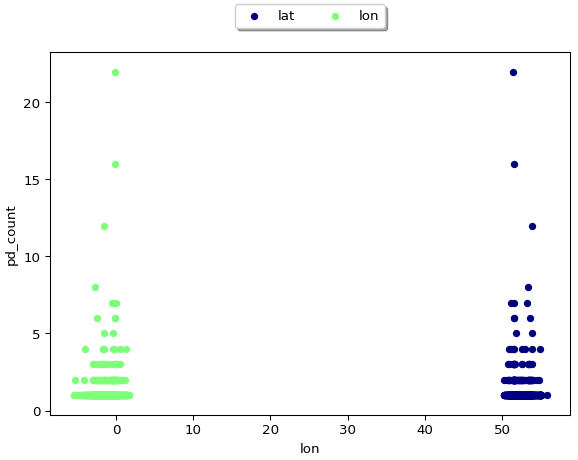

In [ ]:
display(dataset)

* Cloropleth

    ![img2](img/img2.png)

* Cloropleth Cluster
    
    ![img1](img/img1.png)

## References

* https://spark.apache.org/docs/2.3.1/ml-clustering.html
* https://stackoverflow.com/questions/47585723/kmeans-clustering-in-pyspark
* https://pixiedust.github.io/pixiedust/displayapi.html
* https://github.com/pixiedust/pixiedust/wiki/Tutorial:-Using-Notebooks-with-PixieDust-for-Fast,-Flexible,-and-Easier-Data-Analysis-and-Experimentation